# Four Score Multi-class Prediction

# 1. Get Ready for four_score test dataset

## 1-1. Define Lexicon class

In [1]:
class Lexicon:
    def __init__(self,imageName,lex,num):
        self.imageName = imageName
        self.lex = lex 
        self.gt = lex[num]       
        
    def set_image_number(self,number):
        self.image_number = number
    
    def set_image_path(self,path):
        self.image_path = path

In [2]:
import numpy as np

lex_file = './fourscore_labels.txt'
lex = np.loadtxt(lex_file, str, delimiter='\t')

print lex

['four' 'score' 'and' 'seven' 'years' 'ago' 'our' 'fathers' 'brought'
 'forth' 'this' 'continent' 'new' 'nation' 'conceived' 'liberty'
 'dedicated' 'the' 'proposition' 'that' 'all' 'men' 'are' 'created' 'equal']


## 1-2. Choose one testing dataset

* Read 'FS-R-TEST' image data

In [98]:
import os

data_name = 'FS-R-TEST'
path = 'testsets/FS-R-TEST/'

if os.path.exists(path):
    dataList = []
    number = 0
    image_number = 0

    for itera in lex:
        img_path = path + itera
        for root, dirs, files in os.walk(img_path):        
            for f in files:
                imageName = itera + '/' + f
                imageInfo = Lexicon(imageName,lex,number)
                imageInfo.set_image_number(image_number)
                image_number += 1
                dataList.append(imageInfo)
        number += 1

    print len(dataList),"images read"
#     for itera in dataList:
#         print itera.imageName

else:
    print 'data not found'

3750 images read


* Read 'FS-DUCK' image data

In [104]:
import os

data_name = 'FS-DUCK'
path = 'testsets/FS-DUCK/'

if os.path.exists(path):
    dataList = []
    number = 0
    image_number = 0

    for itera in lex:
        img_path = path + str(number) + '_' + itera.upper()
        for root, dirs, files in os.walk(img_path):        
            for f in files:
                imageName = str(number) + '_' + itera.upper() + '/' + f
                imageInfo = Lexicon(imageName,lex,number)
                imageInfo.set_image_number(image_number)

                image_number += 1
                dataList.append(imageInfo)
        number += 1

    print len(dataList),"images read"
#     for itera in dataList:
#         print itera.imageName

else:
    print 'data not found'

809 images read


* Read 'FS-STATA' image data

In [107]:
import os

data_name = 'FS-STATA'
file_path = 'testsets/FS-STATA/'
path = file_path + "images/"
if os.path.exists(path):
    dataList = []
    image_number = 0  
    fpath = np.loadtxt(file_path + "test.txt",str)
    
    for itera in fpath:
        imageName = itera[0]
        imageInfo = Lexicon(imageName,lex,int(itera[1]))
        imageInfo.set_image_number(image_number)
        image_number += 1      
        dataList.append(imageInfo)
        
    print len(dataList),"images read"
#     for itera in dataList:
#         print itera.imageName

else:
    print 'data not found'

238 images read


# 2. Testing Four Score Dictnet 

## 2-1. Get Ready for DICTNET Models

* First, set up Python, `numpy`, and `matplotlib`.

In [4]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
import time
# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

* Load `caffe`.

In [5]:
# The caffe module needs to be on the Python path;
#  we'll add it here explicitly.
import sys
caffe_root = '../../caffe/'  # this file should be run from {caffe_root}/examples (otherwise change this line)
sys.path.insert(0, caffe_root + 'python')

import caffe
# If you get "No module named _caffe", either you have not built pycaffe or you have the wrong path.

* Load net and set up input preprocessing

* Set Caffe to CPU or GPU mode and load the net from disk.

In [60]:
caffe.set_device(0)  # if we have multiple GPUs, pick the first one
caffe.set_mode_gpu()
#caffe.set_mode_cpu()

model_def = 'models/dictnet_fourscore_deploy.prototxt'

# CHOOSE one dictnet model
#model_weights = 'models/FS-DICTNET-VGG/dictnet_vgg_mtoc_s.caffemodel'    #FS-DICTNET-VGG
#model_weights = 'models/FS-DICTNET-REND/_iter_10000.caffemodel'    #FS-DICTNET-REND
#model_weights = 'models/FS-DICTNET-HARV/_iter_10000.caffemodel'    #FS-DICTNET-HARV
model_weights = 'models/FS-DICTNET-R+H/_iter_10000.caffemodel'    #FS-DICTNET-R+H

model_name = model_weights.split("/")[-2]

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)   

## 2-2. Classification

* Now we're ready to perform classification.

In [36]:
# create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
#print net.blobs['data'].data.shape

transformer.set_raw_scale('data', 255)
transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension

net.blobs['data'].reshape(1,        # batch size
                          1,         # 1-channel gray images
                          32, 100)  # image size is 32x100

In [37]:
total_param = 0
for layer_name, param in net.params.iteritems():
    param_num = 1
    for i in range(0,len(param[0].data.shape)):
        param_num *= param[0].data.shape[i]
    param_num += param[1].data.shape[0]
    total_param += param_num
    print layer_name + '\t' + str(param[0].data.shape), str(param[1].data.shape) + '\t' + str(param_num)
print '\nTotal Parameters: ' + str(total_param * 0.000001) + ' millions'

conv1	(64, 1, 5, 5) (64,)	1664
conv2	(128, 64, 5, 5) (128,)	204928
conv3	(256, 128, 3, 3) (256,)	295168
conv3_5	(512, 256, 3, 3) (512,)	1180160
conv4	(512, 512, 3, 3) (512,)	2359808
fc1	(4096, 512, 4, 13) (4096,)	109056000
fc2	(4096, 4096, 1, 1) (4096,)	16781312
fc_class	(25, 4096, 1, 1) (25,)	102425

Total Parameters: 129.981465 millions


* Perform classification

In [38]:
import copy

def classify(net,data,number):
    output = []
    if number == 0:
        length = len(data)
    else:
        length = number
        
    for itera in range(0,length):
        
        #set image path
        img_path = path + data[itera].imageName
        data[itera].set_image_path(img_path)
        
        # import original image and cropped image for prediction
        image = caffe.io.load_image(img_path,False)
        
        # do preprocession
        transformed_image = transformer.preprocess('data', image)
        
        # do mean substraction
        #transformed_image -= np.mean(transformed_image)
        
        # copy the image data into the memory allocated for the net
        net.blobs['data'].data[...] = transformed_image
    
        # perform classification
        out = copy.deepcopy(net.forward())
        output.append(out)
    
    return output

In [67]:
print "classifying......",
output = classify(net,dataList,0)
print "done"
#print output[10]['prob'][0].argmax()

classifying...... done


* Load ImageNet labels

In [4]:
labels_file = './fourscore_labels.txt'

if not os.path.exists(labels_file):
    print 'label file does not exist'

labels = np.loadtxt(labels_file, str, delimiter='\t')
#print labels

* Hit definition: label of max probability in all class same as groundtruth

In [42]:
import itertools
import heapq
def pred(out,data,number):
    lex_hit = 0
    lex_non_hit = 0
    non_hit_case = []
    
    for output,datalist in itertools.izip(out,data):    
        output_prob = output['prob'][0]  # the output probability vector for the first image in the batch

        if number == datalist.image_number:           
            image_number = datalist.image_number
            largest_class = heapq.nlargest(3, xrange(len(output_prob)), key=output_prob.__getitem__)
            largest_prob = heapq.nlargest(3, output_prob)
            ground_truth = datalist.gt.lower()
            image = caffe.io.load_image(datalist.image_path)

        if labels[output_prob.argmax()] == datalist.gt.lower():
            lex_hit += 1
        else:
            lex_non_hit +=1
            non_hit_case.append(datalist.image_number)
    
    print 'model_name:',model_name
    print 'data_name:',data_name,'\n'
    
    print 'hit:',lex_hit,' not hit:',lex_non_hit
    accuracy = lex_hit / float(lex_hit + lex_non_hit)
    print 'accuracy: ', accuracy
    print 'non_hit_case: ', non_hit_case
    
    print '\nimage number:',image_number
    print '1st predicted class is:', labels[largest_class[0]]
    print '    predicted prob is:', largest_prob[0][0][0]
    print '2nd predicted class is:', labels[largest_class[1]]
    print '    predicted prob is:', largest_prob[1][0][0]
    print '3rd predicted class is:', labels[largest_class[2]]
    print '    predicted prob is:', largest_prob[2][0][0]
    print 'ground truth:', ground_truth
    plt.imshow(image)

model_name: FS-DICTNET-R+H
data_name: FS-R-TEST 

hit: 3728  not hit: 22
accuracy:  0.994133333333
non_hit_case:  [77, 178, 212, 264, 1400, 1408, 1442, 1515, 1539, 1803, 1817, 2145, 2230, 2571, 2880, 2881, 3008, 3233, 3265, 3297, 3371, 3483]

image number: 0
1st predicted class is: four
    predicted prob is: 1.0
2nd predicted class is: our
    predicted prob is: 1.52617e-07
3rd predicted class is: brought
    predicted prob is: 1.46727e-08
ground truth: four


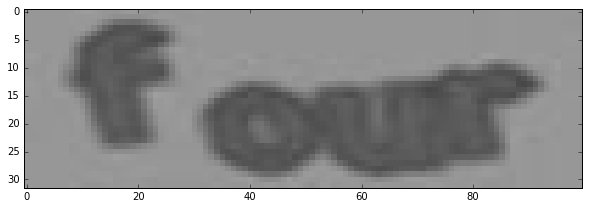

In [68]:
pred(output,dataList,0)

# 3. Testing Four Score CAFFENET 

## 3-1. Get Ready for CAFFENET Models

* First, set up Python, `numpy`, and `matplotlib`.

In [69]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
import time
# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

* Load `caffe`.

In [70]:
# The caffe module needs to be on the Python path;
#  we'll add it here explicitly.
import sys
caffe_root = '../../caffe/'  # this file should be run from {caffe_root}/examples (otherwise change this line)
sys.path.insert(0, caffe_root + 'python')

import caffe
# If you get "No module named _caffe", either you have not built pycaffe or you have the wrong path.

* Load net and set up input preprocessing

* Set Caffe to CPU or GPU mode and load the net from disk.

In [101]:
caffe.set_device(0)  # if we have multiple GPUs, pick the first one
caffe.set_mode_gpu()
#caffe.set_mode_cpu()

model_def = 'models/caffenet_fourscore_deploy.prototxt'

# CHOOSE one dictnet model
#model_weights = 'models/FS-CAFFENET-REND/_iter_10000.caffemodel'    #FS-CAFFENET-REND
#model_weights = 'models/FS-CAFFENET-HARV/_iter_10000.caffemodel'    #FS-CAFFENET-HARV
model_weights = 'models/FS-CAFFENET-R+H/_iter_10000.caffemodel'    #FS-CAFFENET-R+H

model_name = model_weights.split("/")[-2]

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)   

## 3-2. Classification

* Now we're ready to perform classification.

In [91]:
# create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
#print net.blobs['data'].data.shape

mu = np.array([136.0,145.0,154.0])
transformer.set_mean('data', mu) 

transformer.set_raw_scale('data', 255)
transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension

net.blobs['data'].reshape(1,        # batch size
                          3,         # 3-channel images
                          227, 227)  # image size is 227x227
    

In [92]:
total_param = 0
for layer_name, param in net.params.iteritems():
    param_num = 1
    for i in range(0,len(param[0].data.shape)):
        param_num *= param[0].data.shape[i]
    param_num += param[1].data.shape[0]
    total_param += param_num
    print layer_name + '\t' + str(param[0].data.shape), str(param[1].data.shape) + '\t' + str(param_num)
print '\nTotal Parameters: ' + str(total_param * 0.000001) + ' millions'

conv1	(96, 3, 11, 11) (96,)	34944
conv2	(256, 48, 5, 5) (256,)	307456
conv3	(384, 256, 3, 3) (384,)	885120
conv4	(384, 192, 3, 3) (384,)	663936
conv5	(256, 192, 3, 3) (256,)	442624
fc6	(4096, 9216) (4096,)	37752832
fc7	(4096, 4096) (4096,)	16781312
fc8finetune	(25, 4096) (25,)	102425

Total Parameters: 56.970649 millions


* Perform classification

In [82]:
import copy

def classify(net,data,number):
    output = []
    if number == 0:
        length = len(data)
    else:
        length = number
        
    for itera in range(0,length):
        
        #set image path
        img_path = path + data[itera].imageName
        
        # import original image and cropped image for prediction
        image = caffe.io.load_image(img_path)
        data[itera].set_image_path(img_path)
        
        # do preprocession
        transformed_image = transformer.preprocess('data', image)
        
        # do mean substraction
        #transformed_image -= np.mean(transformed_image)
        
        # copy the image data into the memory allocated for the net
        net.blobs['data'].data[...] = transformed_image
    
        # perform classification
        out = copy.deepcopy(net.forward())
        output.append(out)
    
    return output

In [108]:
print "classifying......",
output = classify(net,dataList,0)
print "done"
#print output[10]['prob'][0].argmax()

classifying...... done


* Load ImageNet labels

In [76]:
labels_file = './labels.txt'

if not os.path.exists(labels_file):
    print 'label file does not exist'

labels = np.loadtxt(labels_file, str, delimiter='\t')
#print labels

* Hit definition: label of max probability in all class same as groundtruth

In [85]:
import itertools
import heapq
def pred(out,data,number):
    lex_hit = 0
    lex_non_hit = 0
    non_hit_case = []
    
    for output,datalist in itertools.izip(out,data):    
        output_prob = output['prob'][0]  # the output probability vector for the first image in the batch

        if number == datalist.image_number:           
            image_number = datalist.image_number
            largest_class = heapq.nlargest(3, xrange(len(output_prob)), key=output_prob.__getitem__)
            largest_prob = heapq.nlargest(3, output_prob)
            ground_truth = datalist.gt.lower()
            image = caffe.io.load_image(datalist.image_path)

        if labels[output_prob.argmax()] == datalist.gt.lower():
            lex_hit += 1
        else:
            lex_non_hit +=1
            non_hit_case.append(datalist.image_number)
     
    print 'model_name:',model_name
    print 'data_name:',data_name,'\n'
    
    print 'hit:',lex_hit,' not hit:',lex_non_hit
    accuracy = lex_hit / float(lex_hit + lex_non_hit)
    print 'accuracy: ', accuracy
    print 'non_hit_case: ', non_hit_case
    
    print '\nimage number:',image_number
    print '1st predicted class is:', labels[largest_class[0]]
    print '    predicted prob is:', largest_prob[0]
    print '2nd predicted class is:', labels[largest_class[1]]
    print '    predicted prob is:', largest_prob[1]
    print '3rd predicted class is:', labels[largest_class[2]]
    print '    predicted prob is:', largest_prob[2]
    print 'ground truth:', ground_truth
    plt.imshow(image)

model_name: FS-CAFFENET-R+H
data_name: FS-STATA 

hit: 153  not hit: 85
accuracy:  0.642857142857
non_hit_case:  [13, 16, 17, 21, 24, 25, 29, 43, 49, 50, 51, 55, 56, 58, 63, 64, 67, 68, 70, 71, 72, 73, 74, 76, 77, 80, 84, 86, 88, 89, 90, 92, 95, 97, 98, 102, 105, 106, 109, 111, 112, 113, 123, 128, 130, 132, 135, 144, 146, 149, 150, 151, 154, 156, 157, 161, 162, 163, 171, 173, 174, 178, 179, 180, 184, 188, 190, 193, 194, 197, 199, 200, 202, 205, 206, 208, 209, 210, 211, 221, 222, 223, 225, 226, 237]

image number: 0
1st predicted class is: four
    predicted prob is: 0.963327
2nd predicted class is: new
    predicted prob is: 0.0322213
3rd predicted class is: forth
    predicted prob is: 0.00401129
ground truth: four


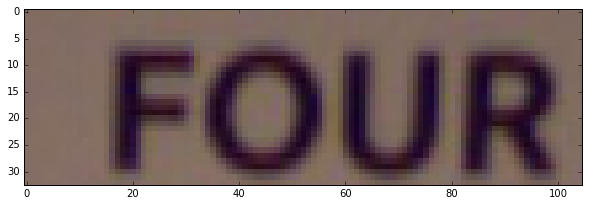

In [109]:
pred(output,dataList,0)